# VAR Analysis: Validator Centrality and Market Volatility

Vector Autoregression (VAR) analysis to examine the dynamic relationships between validator centralization and ETH market volatility.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('../data/processed/daily_regression_data.csv')
df.columns

Index(['miner_rank_1', 'miner_rank_2', 'miner_rank_3', 'miner_rank_4',
       'miner_rank_5', 'miner_rank_6', 'miner_rank_7', 'miner_rank_8',
       'miner_rank_9', 'miner_rank_10', 'miner_rank_11', 'miner_rank_12',
       'miner_rank_13', 'miner_rank_14', 'miner_rank_15', 'miner_rank_16',
       'miner_rank_17', 'miner_rank_18', 'miner_rank_19', 'miner_rank_20',
       'date', 'top1_centrality', 'top10_mean', 'top10_std', 'top20_mean',
       'top20_std', 'top3_centrality', 'top5_centrality', 'top10_centrality',
       'hhi', 'gini', 'eth_marketcap_million', 'eth_return',
       'eth_volume_million', 'eth_intraday_vol', 'open', 'high', 'low',
       'close', 'prof_garman_klass_vol', 'prof_yang_zhang_vol',
       'market_return', 'market_volume_million', 'market_marketcap_million',
       'market_volatility', 'Daily Return', 'yf_garman_klass_vol',
       'yf_yang_zhang_vol', 'eth_turnover', 'market_turnover',
       'prof_garman_klass_vol_lag1', 'yf_garman_klass_vol_lag1',
       'eth_

## 1. Stationarity Testing

Test whether variables are stationary using Augmented Dickey-Fuller (ADF) and KPSS tests.

In [52]:
# =============================================================================
# STEP 1: STATIONARITY TESTING
# =============================================================================

# Test key variables for stationarity
variables_to_test = {
    'eth_return': 'ETH Return',
    'eth_turnover': 'ETH Turnover',
    'market_volatility': 'Market Volatility',
    'top1_centrality': 'Top 1% Centrality',
    'top10_mean': 'Top 10 Mean',
    'top10_std': 'Top 10 Std Dev',
    'top20_mean': 'Top 20 Mean',
    'top20_std': 'Top 20 Std Dev',
    'top3_centrality': 'Top 3% Centrality',
    'top5_centrality': 'Top 5% Centrality',
    'top10_centrality': 'Top 10% Centrality',
    'hhi': 'Herfindahl-Hirschman Index',
    'gini': 'Gini Coefficient'
}

stationarity_results = {}

print("\n" + "="*80)
print("STATIONARITY TESTING")
print("="*80)

for var, name in variables_to_test.items():
    print(f"\n=== Testing {name} ({var}) ===")

    series = df[var].dropna()

    # ADF Test (H0: non-stationary, i.e., has unit root)
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Test:")
    print(f"  Test Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values (1%, 5%, 10%): {adf_result[4]}")
    adf_stationary = adf_result[1] < 0.05
    print(f"  Stationary (ADF): {'Yes' if adf_stationary else 'No'}")

    # KPSS Test (H0: stationary around trend)
    try:
        kpss_result = kpss(series, regression='c')
        print(f"KPSS Test:")
        print(f"  Test Statistic: {kpss_result[0]:.4f}")
        print(f"  p-value: {kpss_result[1]:.4f}")
        print(f"  Critical Values (10%, 5%, 2.5%, 1%): {kpss_result[3]}")
        kpss_stationary = kpss_result[1] > 0.05
        print(f"  Stationary (KPSS): {'Yes' if kpss_stationary else 'No'}")

        # Combined conclusion
        if adf_stationary and kpss_stationary:
            conclusion = "STATIONARY"
        elif not adf_stationary and not kpss_stationary:
            conclusion = "NON-STATIONARY"
        else:
            conclusion = "INCONCLUSIVE - Consider first differencing"

    except Exception as e:
        print(f"  KPSS test failed: {e}")
        conclusion = "STATIONARY" if adf_stationary else "NON-STATIONARY"

    print(f"  Final Conclusion: {conclusion}")
    stationarity_results[var] = {
        'name': name,
        'adf_pvalue': adf_result[1],
        'adf_stationary': adf_stationary,
        'conclusion': conclusion
    }

# Summary of stationarity results
print("\n" + "="*50)
print("STATIONARITY SUMMARY")
print("="*50)
for var, result in stationarity_results.items():
    print(
        f"{result['name']}: {result['conclusion']} (ADF p-value: {result['adf_pvalue']:.4f})")


STATIONARITY TESTING

=== Testing ETH Return (eth_return) ===
ADF Test:
  Test Statistic: -12.7011
  p-value: 0.0000
  Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.433936263195097), '5%': np.float64(-2.8631241351249), '10%': np.float64(-2.5676133397235263)}
  Stationary (ADF): Yes
KPSS Test:
  Test Statistic: 0.4175
  p-value: 0.0696
  Critical Values (10%, 5%, 2.5%, 1%): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  Stationary (KPSS): Yes
  Final Conclusion: STATIONARY

=== Testing ETH Turnover (eth_turnover) ===
ADF Test:
  Test Statistic: -3.2239
  p-value: 0.0186
  Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.433968010099092), '5%': np.float64(-2.8631381499714745), '10%': np.float64(-2.567620802173316)}
  Stationary (ADF): Yes
KPSS Test:
  Test Statistic: 2.9215
  p-value: 0.0100
  Critical Values (10%, 5%, 2.5%, 1%): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  Stationary (KPSS): No
  Final Conclusion: INCONCLUSIVE - Consider first differenc

In [53]:
# =============================================================================
# STEP 2: FIRST DIFFERENCING (if needed)
# =============================================================================

# Create first differences for non-stationary variables
print("\n" + "="*80)
print("CREATING FIRST DIFFERENCES FOR NON-STATIONARY VARIABLES")
print("="*80)

non_stationary_vars = [var for var, result in stationarity_results.items()
                       if result['conclusion'] in ['NON-STATIONARY', 'INCONCLUSIVE - Consider first differencing', 'STATIONARY']]

print(f"Variables that may need differencing: {non_stationary_vars}")

# Create differenced versions
df_analysis = df.copy()
differenced_vars = {}

for var in non_stationary_vars:
    diff_var = f"{var}_diff"
    df_analysis[diff_var] = df_analysis[var].diff()
    differenced_vars[var] = diff_var

    # Test stationarity of differenced series
    print(f"\nTesting stationarity of differenced {var}:")
    series_diff = df_analysis[diff_var].dropna()
    adf_result = adfuller(series_diff, autolag='AIC')
    print(f"  ADF p-value: {adf_result[1]:.4f}")
    print(f"  Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")


CREATING FIRST DIFFERENCES FOR NON-STATIONARY VARIABLES
Variables that may need differencing: ['eth_return', 'eth_turnover', 'market_volatility', 'top1_centrality', 'top10_mean', 'top10_std', 'top20_mean', 'top20_std', 'top3_centrality', 'top5_centrality', 'top10_centrality', 'hhi', 'gini']

Testing stationarity of differenced eth_return:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced eth_turnover:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced market_volatility:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top1_centrality:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top10_mean:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top10_std:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top20_mean:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top20_std:
  ADF p-value: 0.0000
 

## 2. First Differencing

Apply first differencing to non-stationary variables to achieve stationarity.


TIME SERIES VISUALIZATION


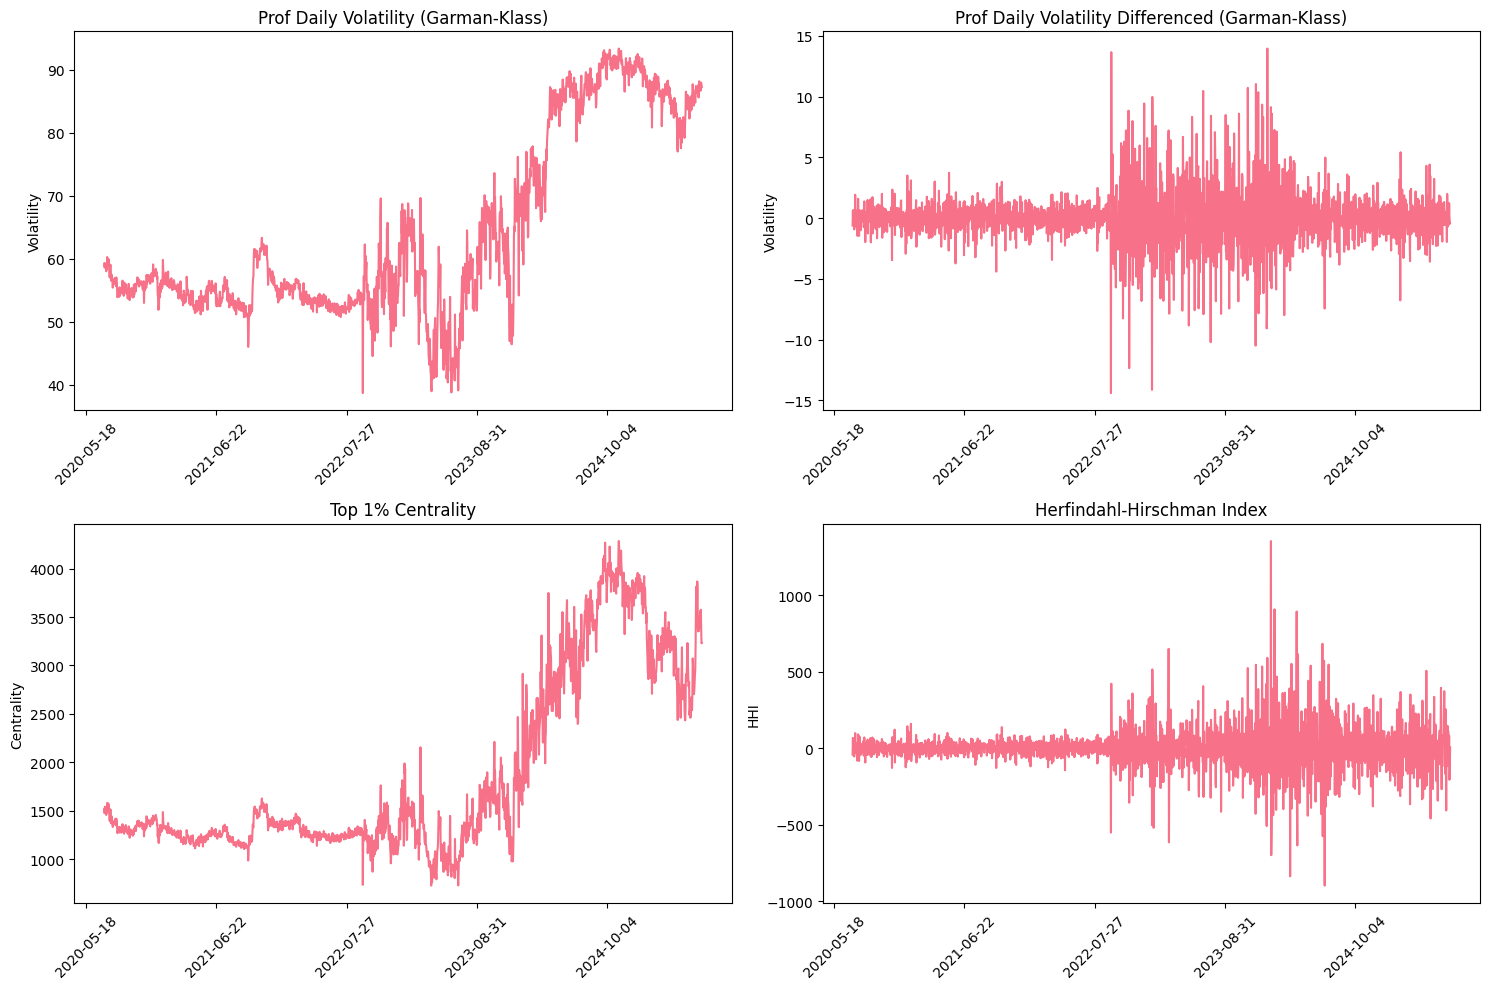

In [54]:
# =============================================================================
# STEP 3: VISUALIZATION OF TIME SERIES
# =============================================================================

print("\n" + "="*80)
print("TIME SERIES VISUALIZATION")
print("="*80)

# Convert date to datetime if not already
df['date'] = pd.to_datetime(df['date'])
df_analysis['date'] = pd.to_datetime(df_analysis['date'])

# Plot volatility measures
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ETH Volatility
axes[0, 0].plot(df['date'], df['top3_centrality'])
axes[0, 0].set_title('Prof Daily Volatility (Garman-Klass)')
axes[0, 0].set_ylabel('Volatility')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].xaxis.set_major_locator(plt.MaxNLocator(6))  # Limit to ~6 labels

# ETH Volatility Differenced
axes[0, 1].plot(df_analysis['date'], df_analysis['top3_centrality_diff'])
axes[0, 1].set_title('Prof Daily Volatility Differenced (Garman-Klass)')
axes[0, 1].set_ylabel('Volatility')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].xaxis.set_major_locator(plt.MaxNLocator(6))

# Top 1% Centrality
axes[1, 0].plot(df['date'], df['hhi'])
axes[1, 0].set_title('Top 1% Centrality')
axes[1, 0].set_ylabel('Centrality')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].xaxis.set_major_locator(plt.MaxNLocator(6))

# HHI
axes[1, 1].plot(df_analysis['date'], df_analysis['hhi_diff'])
axes[1, 1].set_title('Herfindahl-Hirschman Index')
axes[1, 1].set_ylabel('HHI')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].xaxis.set_major_locator(plt.MaxNLocator(6))

plt.tight_layout()
plt.show()

## 3. Granger Causality Tests

Test whether past values of centrality measures help predict future volatility.

In [55]:
print("\n" + "="*80)
print("GRANGER CAUSALITY ANALYSIS")
print("="*80)

# Define variables for Granger causality testing
volatility_var = 'prof_yang_zhang_vol'  # Changed from weekly_vol_annualized

# Use the actual differenced variable names that exist in df_analysis
# Check which variables were differenced in Step 2
centrality_vars = ['top1_centrality_diff', 'top3_centrality_diff', 'top5_centrality_diff',
                   'top10_centrality_diff', 'hhi_diff', 'gini_diff']

# Test each centrality variable against volatility
granger_results = {}

for centrality_var in centrality_vars:
    print(f"\n{'='*60}")
    print(f"Testing: Does {centrality_var} Granger-cause {volatility_var}?")
    print(f"H0: {centrality_var} does NOT Granger-cause {volatility_var}")
    print(f"{'='*60}")

    # Create dataframe with the two variables (remove NaN values)
    test_data = df_analysis[[centrality_var, volatility_var]].dropna()

    # Granger causality test - INCREASED max_lags for daily data
    # Increased from 8 to 20 for daily data
    max_lags = min(20, len(test_data)//10)

    try:
        gc_result = grangercausalitytests(
            test_data, maxlag=max_lags, verbose=False)

        print(f"Sample size: {len(test_data)} observations")
        print(f"Testing lags 1 to {max_lags}")
        print("\nResults by lag:")

        # Extract p-values for each lag
        lag_results = {}
        for lag in range(1, max_lags + 1):
            # Get F-test p-value (most common test)
            f_test_pval = gc_result[lag][0]['ssr_ftest'][1]
            lag_results[lag] = f_test_pval

            significance = "***" if f_test_pval < 0.01 else "**" if f_test_pval < 0.05 else "*" if f_test_pval < 0.1 else ""
            print(
                f"  Lag {lag}: F-test p-value = {f_test_pval:.4f} {significance}")

        # Overall assessment
        min_pval = min(lag_results.values())
        best_lag = min(lag_results, key=lag_results.get)

        print(f"\nBest result: Lag {best_lag} with p-value = {min_pval:.4f}")

        if min_pval < 0.05:
            print(
                f"CONCLUSION: {centrality_var} DOES Granger-cause {volatility_var} at 5% level")
        elif min_pval < 0.10:
            print(
                f"CONCLUSION: {centrality_var} WEAKLY Granger-causes {volatility_var} at 10% level")
        else:
            print(
                f"CONCLUSION: {centrality_var} does NOT Granger-cause {volatility_var}")

        granger_results[centrality_var] = {
            'min_pvalue': min_pval,
            'best_lag': best_lag,
            'significant_5pct': min_pval < 0.05,
            'significant_10pct': min_pval < 0.10
        }

    except Exception as e:
        print(f"Error testing {centrality_var}: {e}")
        granger_results[centrality_var] = {'error': str(e)}

# Summary of all results
print(f"\n{'='*80}")
print("GRANGER CAUSALITY SUMMARY")
print(f"{'='*80}")
print(f"{'Variable':<25} {'Min P-value':<12} {'Best Lag':<10} {'Significant?':<12}")
print(f"{'-'*60}")

for var, result in granger_results.items():
    if 'error' not in result:
        sig_text = "Yes (5%)" if result['significant_5pct'] else "Yes (10%)" if result['significant_10pct'] else "No"
        print(
            f"{var:<25} {result['min_pvalue']:<12.4f} {result['best_lag']:<10} {sig_text:<12}")
    else:
        print(f"{var:<25} {'ERROR':<12} {'-':<10} {'-':<12}")

print(f"\n{'='*60}")
print("INTERPRETATION:")
print("- Granger causality tests if past values of X help predict Y")
print("- Significant p-values (< 0.05) suggest X Granger-causes Y")
print("- This indicates predictive relationships, not necessarily true causation")
print("- Daily data: Testing up to 20 lags (~3-4 weeks of trading days)")
print(f"{'='*60}")


GRANGER CAUSALITY ANALYSIS

Testing: Does top1_centrality_diff Granger-cause prof_yang_zhang_vol?
H0: top1_centrality_diff does NOT Granger-cause prof_yang_zhang_vol
Sample size: 1835 observations
Testing lags 1 to 20

Results by lag:
  Lag 1: F-test p-value = 0.3596 
  Lag 2: F-test p-value = 0.4587 
  Lag 3: F-test p-value = 0.4716 
  Lag 4: F-test p-value = 0.5296 
  Lag 5: F-test p-value = 0.6467 
  Lag 6: F-test p-value = 0.7373 
  Lag 7: F-test p-value = 0.5865 
  Lag 8: F-test p-value = 0.6776 
  Lag 9: F-test p-value = 0.7593 
  Lag 10: F-test p-value = 0.6349 
  Lag 11: F-test p-value = 0.4135 
  Lag 12: F-test p-value = 0.5114 
  Lag 13: F-test p-value = 0.5387 
  Lag 14: F-test p-value = 0.6236 
  Lag 15: F-test p-value = 0.6602 
  Lag 16: F-test p-value = 0.7450 
  Lag 17: F-test p-value = 0.7980 
  Lag 18: F-test p-value = 0.8266 
  Lag 19: F-test p-value = 0.8193 
  Lag 20: F-test p-value = 0.8426 

Best result: Lag 1 with p-value = 0.3596
CONCLUSION: top1_centrality_dif

## 4. VAR Model Estimation

Estimate VAR model and analyze impulse response functions and variance decomposition.

In [56]:
print("\n" + "="*80)
print("VECTOR AUTOREGRESSION (VAR) ANALYSIS")
print("="*80)

# PREPARE DATA FOR VAR

# 1. MOST EXOGENOUS: Network/structural variables (the predictor)
network_vars = ['top3_centrality']

# 2. Market-wide control variables
market_vars = [
    'market_volatility',        # Market volatility
    'market_return',              # Broad market returns
    'market_turnover'             # Market-wide liquidity
]

# 3. ETH-specific variables
eth_vars = [
    'eth_return',                 # ETH returns
    'eth_turnover'                # ETH-specific liquidity
]

# 4. MOST ENDOGENOUS: Volatility (the outcome being predicted)
volatility_vars = [
    # 'eth_intraday_vol',
    # 'prof_garman_klass_vol'               # What we're trying to predict
    'prof_yang_zhang_vol'
    # 'yf_garman_klass_vol'
    # 'yf_yang_zhang_vol'
]

# Combine in order: predictor → controls → outcome
all_vars = network_vars + market_vars + eth_vars + volatility_vars
var_ordering = all_vars
# var_ordering.reverse()

print(f"Predictor (most exogenous): {network_vars}")
print(f"Market controls: {market_vars}")
print(f"ETH controls: {eth_vars}")
print(f"Outcome (most endogenous): {volatility_vars}")
print(f"\nVAR ordering:")
for i, var in enumerate(var_ordering, 1):
    print(f"  {i}. {var}")

# Prepare data
var_data = df_analysis[all_vars].dropna()
print(f"\nSample size after removing NaN: {len(var_data)} observations")
print(
    f"Sample period: {df_analysis.loc[var_data.index[0], 'date']} to {df_analysis.loc[var_data.index[-1], 'date']}")

# Standardize variables (optional but recommended)
var_data_scaled = pd.DataFrame(
    (var_data - var_data.mean()) / var_data.std(),
    columns=var_data.columns,
    index=var_data.index
)


VECTOR AUTOREGRESSION (VAR) ANALYSIS
Predictor (most exogenous): ['top3_centrality']
Market controls: ['market_volatility', 'market_return', 'market_turnover']
ETH controls: ['eth_return', 'eth_turnover']
Outcome (most endogenous): ['prof_yang_zhang_vol']

VAR ordering:
  1. top3_centrality
  2. market_volatility
  3. market_return
  4. market_turnover
  5. eth_return
  6. eth_turnover
  7. prof_yang_zhang_vol

Sample size after removing NaN: 1836 observations
Sample period: 2020-07-13 00:00:00 to 2025-07-22 00:00:00



ESTIMATING VAR MODEL
Lag selection criteria:
  aic: 8 lags
  bic: 2 lags
  hqic: 8 lags
  fpe: 8 lags

Using 8 lags (AIC criterion)

VAR(8) model estimated successfully
Model summary:
  Number of equations: 7
  Number of observations used: 1828
  Number of parameters: 63

PLOTTING IMPULSE RESPONSE FUNCTIONS


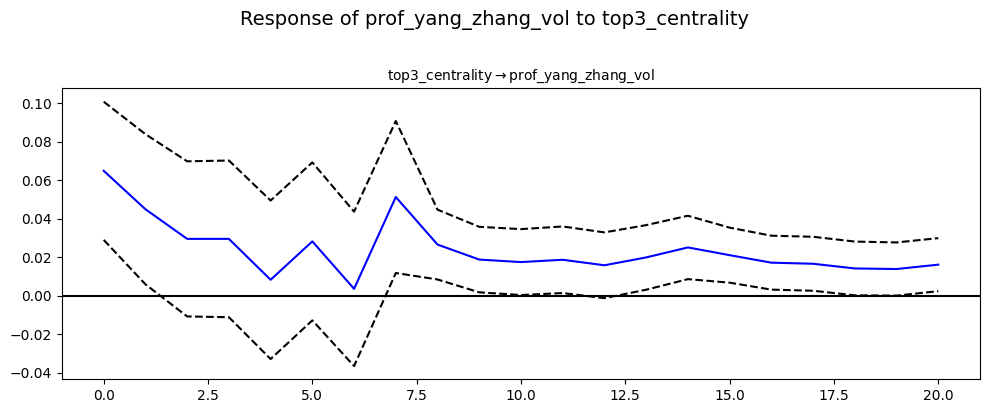

In [57]:
print(f"\n{'='*60}")
print("ESTIMATING VAR MODEL")
print(f"{'='*60}")

# Fit VAR model
model = VAR(var_data_scaled)

# Select optimal lag length
lag_selection = model.select_order(maxlags=8)
print("Lag selection criteria:")
for criterion, lags in lag_selection.selected_orders.items():
    print(f"  {criterion}: {lags} lags")

# Use AIC-selected lag (or manually choose)
optimal_lags = lag_selection.selected_orders['aic']
print(f"\nUsing {optimal_lags} lags (AIC criterion)")

# Estimate VAR
var_model = model.fit(optimal_lags)
print(f"\nVAR({optimal_lags}) model estimated successfully")
print(f"Model summary:")
print(f"  Number of equations: {var_model.neqs}")
print(f"  Number of observations used: {var_model.nobs}")
print(
    f"  Number of parameters: {var_model.k_ar * var_model.neqs + var_model.neqs}")

# =============================================================================
# IMPULSE RESPONSE FUNCTIONS (BUILT-IN METHOD)
# =============================================================================

print(f"\n{'='*60}")
print("PLOTTING IMPULSE RESPONSE FUNCTIONS")
print(f"{'='*60}")

# Use built-in IRF plotting with bootstrap confidence intervals
irf = var_model.irf(periods=20)

# Plot all IRFs with confidence bands
# fig = irf.plot(orth=True, figsize=(30, 25), subplot_params={'fontsize': 10})
# plt.suptitle(
#     'Impulse Response Functions with 95% Confidence Intervals', fontsize=16)
# plt.savefig('../results/irf_all_variables.png', dpi=200, bbox_inches='tight')
# plt.show()

# Plot only responses to network shock
# shock_idx = all_vars.index('top3_centrality')
# fig = irf.plot(orth=True, impulse=shock_idx, figsize=(7, 10),
#                subplot_params={'fontsize': 10})
# plt.suptitle('Responses to Top3 Centrality Shock', fontsize=16)
# # plt.savefig('../results/irf_top1_centrality_shock.png', dpi=200, bbox_inches='tight')
# plt.show()

# Plot only volatility responses to network shock
shock_idx = all_vars.index(network_vars[0])  # e.g., 'top3_centrality'
response_idx = all_vars.index(volatility_vars[0])  # e.g., 'prof_garman_klass_vol'
fig = irf.plot(orth=True, impulse=shock_idx, response=response_idx, figsize=(10, 4), subplot_params={'fontsize': 10})
plt.suptitle(f'Response of {volatility_vars[0]} to {network_vars[0]}', fontsize=14, y=1.02)
plt.tight_layout()
# plt.savefig('irf_top1_centrality_to_volatility.png', dpi=200, bbox_inches='tight')
plt.show()